In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import urllib.request
import xml.etree.ElementTree as ET
import plotly.graph_objects as go
import plotly.io as pio
import psycopg2


from datetime import datetime
from pymongo import MongoClient

ModuleNotFoundError: No module named 'psycopg2'

In [245]:
# Connecting to MongoDB
mongo_client = MongoClient("mongodb://localhost:27017/")
project_db = mongo_client["projectdb"]

In [246]:
# Reading unemployment-statistics data
unemployment_statistics_url = "https://data.ny.gov/api/views/dh9m-5v4d/rows.json?accessType=DOWNLOAD"
unemployment_statistics_response = urllib.request.urlopen(unemployment_statistics_url)
unemployment_statistics_data = json.loads(unemployment_statistics_response.read())

# inserting into mongoDB
unemployment_statistics_collection = project_db["unemployment_statistics"]
unemployment_statistics_cols = list(filter(lambda val: val["id"] != -1, unemployment_statistics_data["meta"]["view"]["columns"]))
unemployment_statistics_cols_others_len = len(list(filter(lambda val: val["id"] == -1, unemployment_statistics_data["meta"]["view"]["columns"])))

for row in unemployment_statistics_data["data"]:
    db_row = {}
    for col in unemployment_statistics_cols:
        db_row[col["fieldName"]] = row[int(col["position"]) + unemployment_statistics_cols_others_len - 1]
    unemployment_statistics_collection.insert_one(db_row)

print("Inserted unemployment_statistics document count: ", unemployment_statistics_collection.count_documents({}))

Inserted unemployment_statistics document count:  1686


In [247]:
# Reading covid_cases
covid_cases_url = "https://data.cityofnewyork.us/api/views/rc75-m7u3/rows.json?accessType=DOWNLOAD"
covid_cases_response = urllib.request.urlopen(covid_cases_url)
covid_cases_data = json.loads(covid_cases_response.read())

# inserting into mongoDB
covid_cases_collection = project_db["covid_cases"]
covid_cases_cols = list(filter(lambda val: val["id"] != -1, covid_cases_data["meta"]["view"]["columns"]))
covid_cases_cols_others_len = len(list(filter(lambda val: val["id"] == -1, covid_cases_data["meta"]["view"]["columns"])))


for row in covid_cases_data["data"]:
    db_row = {}
    for col in covid_cases_cols:
        db_row[col["fieldName"].lower()] = row[int(col["position"]) + covid_cases_cols_others_len - 1]
    covid_cases_collection.insert_one(db_row)

print("Inserted air_quality document count: ",covid_cases_collection.count_documents({}))

Inserted air_quality document count:  1018


In [248]:
# Reading air_quality
air_quality_url = "https://data.cityofnewyork.us/api/views/c3uy-2p5r/rows.xml?accessType=DOWNLOAD"
air_quality_response = urllib.request.urlopen(air_quality_url)
air_quality_xml = ET.parse(air_quality_response)
air_quality_xml_root = air_quality_xml.getroot()
air_quality_data = []

# inserting into mongoDB
air_quality_collection = project_db["air_quality"]
for row in air_quality_xml_root[0].findall('row'):
    air_quality_data_row = {}
    for elem in row.iter():
        if elem is not row:
            air_quality_data_row[elem.tag.lower().replace(' ', '_')] = elem.text
    if len(air_quality_data_row) != 0:
        air_quality_collection.insert_one(air_quality_data_row)
print("Inserted air_quality document count: ", air_quality_collection.count_documents({}))

Inserted air_quality document count:  16122


In [336]:
# creating table in postgress
conn = psycopg2.connect(database="postgres",
                        host="localhost",
                        user="postgres",
                        password="",
                        port="5432")

cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS unemployment_statistics;CREATE TABLE unemployment_statistics (unemployment_statistics_id serial PRIMARY KEY, date_of_interest TIMESTAMP NOT NULL, area VARCHAR(255), labor_force BIGINT, employed BIGINT, unemployed BIGINT, unemployment_rate REAL);")
cursor.execute("DROP TABLE IF EXISTS covid_cases;CREATE TABLE covid_cases (covid_cases_id serial PRIMARY KEY, date_of_interest TIMESTAMP NOT NULL, case_count INTEGER);")
cursor.execute("DROP TABLE IF EXISTS air_quality;CREATE TABLE air_quality (air_quality_id serial PRIMARY KEY, date_of_interest TIMESTAMP NOT NULL, data_value REAL);")
cursor.close()

In [337]:
unemployment_statistics_collection = project_db["unemployment_statistics"]

cursor = conn.cursor()
for row in unemployment_statistics_collection.find():
    date = row["year"]+"-"+row["month"]+"-01"
    cursor.execute("INSERT INTO unemployment_statistics (date_of_interest, area, labor_force, employed, unemployed, unemployment_rate) VALUES (%s,%s,%s,%s,%s,%s)", (date, row["area"], row["labor_force"], row["employed"], row["unemployed"], row["unemployment_rate"]))
cursor.close()

In [338]:
covid_cases_collection = project_db["covid_cases"]

cursor = conn.cursor()
for row in covid_cases_collection.find():
    date = row["date_of_interest"]
    cursor.execute("INSERT INTO covid_cases (date_of_interest, case_count) VALUES (%s,%s)", (date, row["case_count"]))
cursor.close()

In [339]:
air_quality_collection = project_db["air_quality"]

cursor = conn.cursor()
for row in air_quality_collection.find():
    date = row["start_date"]
    cursor.execute("INSERT INTO air_quality (date_of_interest, data_value) VALUES (%s,%s)", (date, row["data_value"]))
cursor.close()

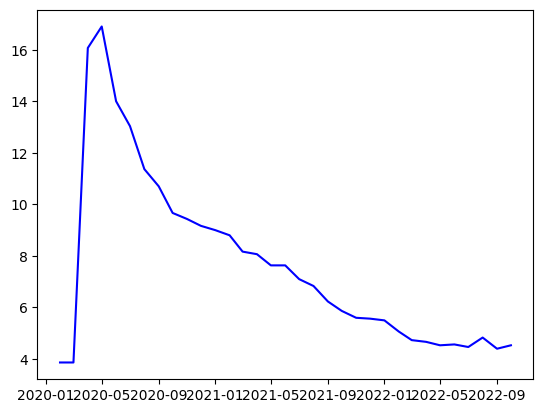

In [340]:
cursor = conn.cursor();
cursor.execute("SELECT date_of_interest, avg(unemployment_rate) FROM unemployment_statistics where date_of_interest > '2020-01-01' group by date_of_interest order by date_of_interest asc ")
unemployment_rate = cursor.fetchall()
cursor.close()

unemployment_rate_graph_x = []
unemployment_rate_graph_y = []
for item in unemployment_rate:
    date_of_interest, value = item
    unemployment_rate_graph_x.append(date_of_interest)
    unemployment_rate_graph_y.append(value)
plt.plot(unemployment_rate_graph_x, unemployment_rate_graph_y, color='blue', label='unemployment_rate')



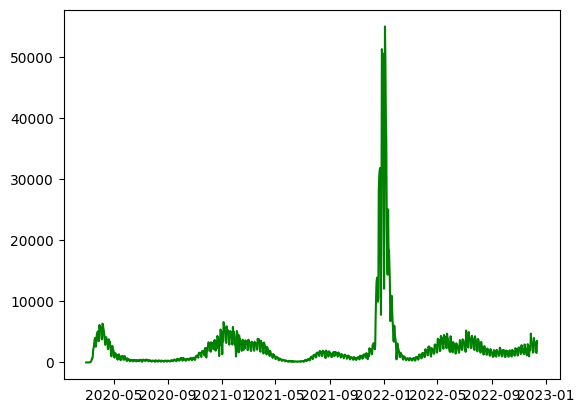

In [344]:
cursor = conn.cursor();
cursor.execute("SELECT date_of_interest, avg(case_count) FROM covid_cases  where date_of_interest > '2020-01-01' group by date_of_interest order by date_of_interest asc")
covid_cases = cursor.fetchall()
cursor.close()

covid_cases_graph_x = []
covid_cases_graph_y = []
for item in covid_cases:
    date_of_interest, value = item
    covid_cases_graph_x.append(date_of_interest)
    covid_cases_graph_y.append(value)
plt.plot(covid_cases_graph_x, covid_cases_graph_y,  color='green', label='covid_cases')



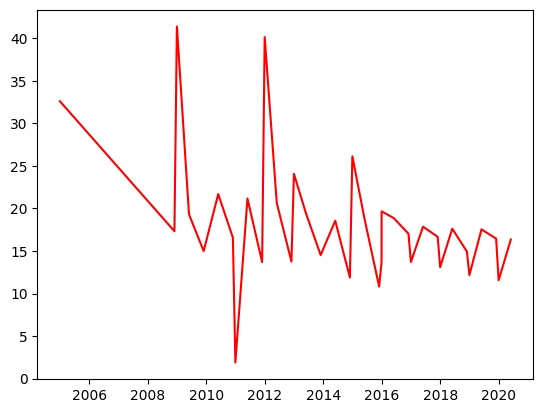

In [350]:
cursor = conn.cursor();
cursor.execute("SELECT date_of_interest, avg(data_value) FROM air_quality group by date_of_interest order by date_of_interest asc")
air_quality = cursor.fetchall()
cursor.close()

air_quality_graph_x = []
air_quality_graph_y = []
for item in air_quality:
    date_of_interest, data_value = item
#     print(datetime.strptime(date_of_interest, "%Y-%m-%d %h:%m:%s"))
    air_quality_graph_x.append(date_of_interest)
    air_quality_graph_y.append(data_value)
plt.plot(air_quality_graph_x, air_quality_graph_y, color='red', label='air_quality')



16.89999993642171


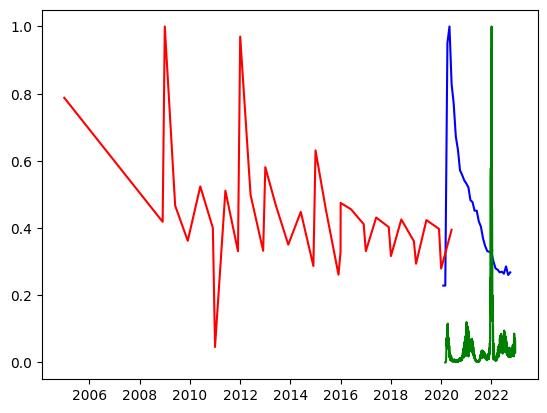

In [343]:


print(max(unemployment_rate_graph_y))

plt.plot(unemployment_rate_graph_x, list(map(lambda x: x / max(unemployment_rate_graph_y), unemployment_rate_graph_y)), color='blue', label='unemployment_rate')
plt.plot(covid_cases_graph_x, list(map(lambda x: x / max(covid_cases_graph_y), covid_cases_graph_y)),  color='green', label='covid_cases')
plt.plot(air_quality_graph_x,  list(map(lambda x: x / max(air_quality_graph_y), air_quality_graph_y)), color='red', label='air_quality')


